In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
print(train_df.shape) #shape of the training dataframe 
print(test_df.shape) #shape of the test dataframe

(20000, 22)
(5000, 21)


In [3]:
pd.set_option('display.max_columns', None) #making it so that when printing the head it does not skip few columns
train_df.head()#printing first few rows of data

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,1.0,0385,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,2.0,0329 1202,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,1.0,0329 1300,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,1.0,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [4]:
unique_values = train_df.nunique()
null_counts = train_df.isna().sum()
data_types = train_df.dtypes

summary_df = pd.DataFrame({
    'Unique Values': unique_values,
    'Null Counts': null_counts,
    'Data Types': data_types
})

print(summary_df)

                       Unique Values  Null Counts Data Types
Location                       12399            0     object
Cross_Street                    1495        16552     object
Latitude                        3622            0    float64
Longitude                       3578            0    float64
Date_Reported                    811            0     object
Date_Occurred                    366            0     object
Time_Occurred                    996            0    float64
Area_ID                           21            0    float64
Area_Name                         21            0     object
Reporting_District_no           1120            0    float64
Part 1-2                           2            0    float64
Modus_Operandi                 10489         2741     object
Victim_Age                       100            0    float64
Victim_Sex                         4         2624     object
Victim_Descent                    17         2624     object
Premise_Code            

In [5]:
#area code and area name should have a one to one correspondence meaning we can drop the name column without any difference in the final model 
#we must ensure that the first statement is true so this is a test to verify if the two columns have correspondence

df = train_df.copy()
column1 = "Area_ID"
column2 = "Area_Name"
grouped = df.groupby(column1)[column2].nunique() # Group by the first column and get the unique values of the second column for each group
consistent = grouped[grouped > 1] # Check if each group has exactly one unique value

if consistent.empty:
    print("correspondence present")
else:
    print("correspondence not present")
    print(consistent)

    
# in the same way we can also remove the columns weapon used description and premise description

correspondence present


### *Based on this preliminary analysis of the data I will drop the location, cross_street and reporting district columns because latitude and longitude should be enough location data.* 

### *From the date_reported and Date occured columns we can extract the date and the month of the crime. Since the dates are not stored in a standard format we'll have to extract the digits from the strings.*

### *The columns area_name, premise description, and weapon_description are redundant because these have a corresponding 'code' which should have a one to one correspondence with these columns.*

### *We'll use tfidf vectorizer on the modus operandi column and one hot encode the rest of the columns*

### *Then we'll scale all the numerical columns with standard scaler as it helps a lot of classification algorithms converge faster and perform better*

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_counts(col,df):
    counts = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values, palette='viridis')
    plt.title(f'Value Counts of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()
    
def plot_counts_hue(col,df):
    value_counts = df.groupby(['Crime_Category', col]).size().reset_index(name='counts')
    plt.figure(figsize=(20, 6))
    sns.barplot(x=col, y='counts', hue='Crime_Category', data=value_counts)
    plt.xlabel('col')
    plt.ylabel('Counts')
    plt.title(f'Value Counts of {col} Grouped by Target Column')
    plt.legend(title='Target Column')
    plt.tight_layout()
    plt.show()

In [7]:
#extracting the dates from the columns
train_df['Month_Reported'] = train_df['Date_Reported'].str[:2].astype(int)
train_df['Day_Reported'] = train_df['Date_Reported'].str[3:5].astype(int)
train_df['Month_Occurred'] = train_df['Date_Occurred'].str[:2].astype(int)
train_df['Day_Occurred'] = train_df['Date_Occurred'].str[3:5].astype(int)

test_df['Month_Reported'] = test_df['Date_Reported'].str[:2].astype(int)
test_df['Day_Reported'] = test_df['Date_Reported'].str[3:5].astype(int)
test_df['Month_Occurred'] = test_df['Date_Occurred'].str[:2].astype(int)
test_df['Day_Occurred'] = test_df['Date_Occurred'].str[3:5].astype(int)

#handling invalid values in the age column
train_df['Victim_Age'] = train_df['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
#handling unknown values in the victim sex and victim descent columns
train_df['Victim_Sex'] = train_df['Victim_Sex'].fillna('X')
train_df['Victim_Descent'] = train_df['Victim_Descent'].fillna('X')

#the unknown values in the latitude and longitude columns are already 0

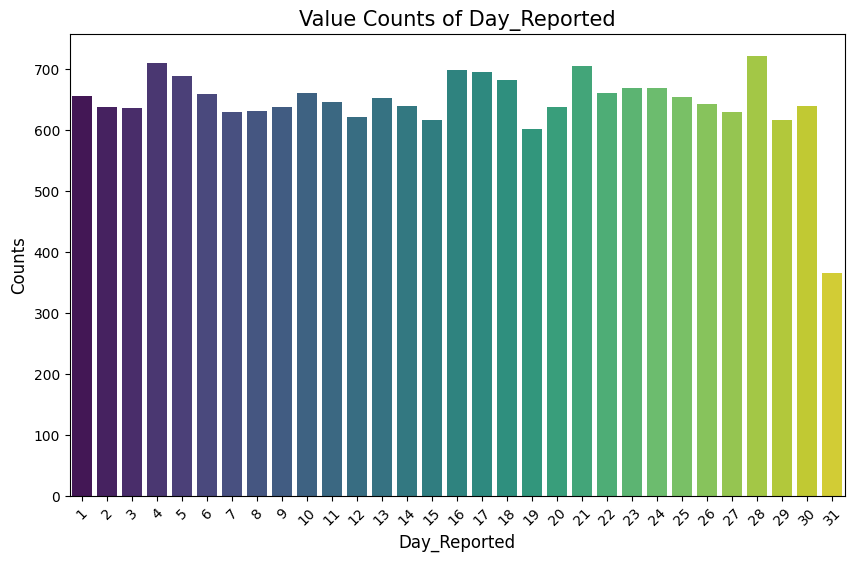

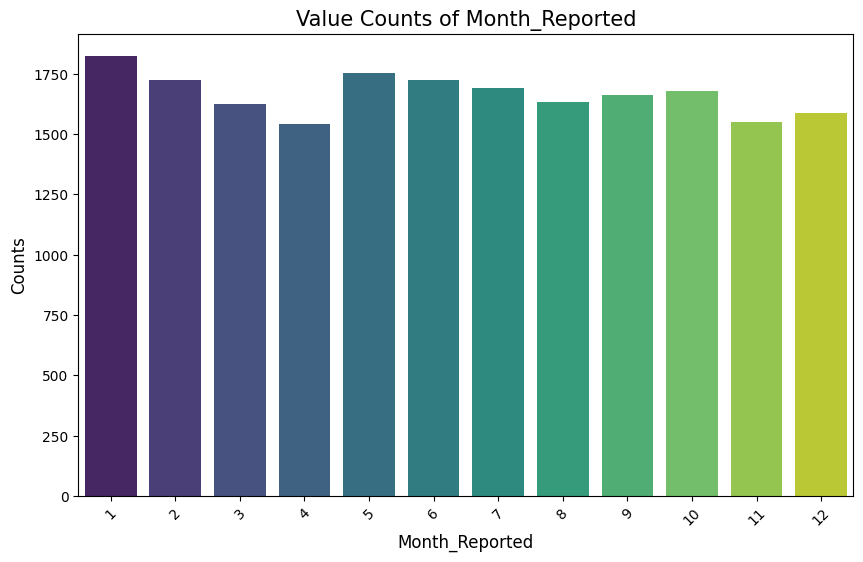

In [8]:
plot_counts('Day_Reported',train_df)
plot_counts('Month_Reported',train_df)
#from these plots we can see that the crimes are pretty evenly distributed across the months and the dates(600-700 range)
#only the 31st is significantly less common than the rest because only 7 months have 31 days in them
#we see a decrease in number of crimes from january to april and even after crime increases in may it keeps decreasing through august 

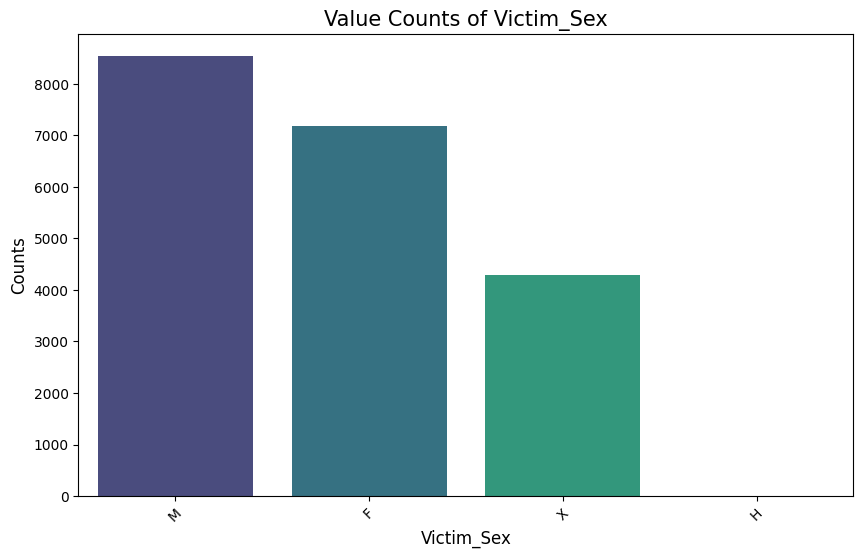

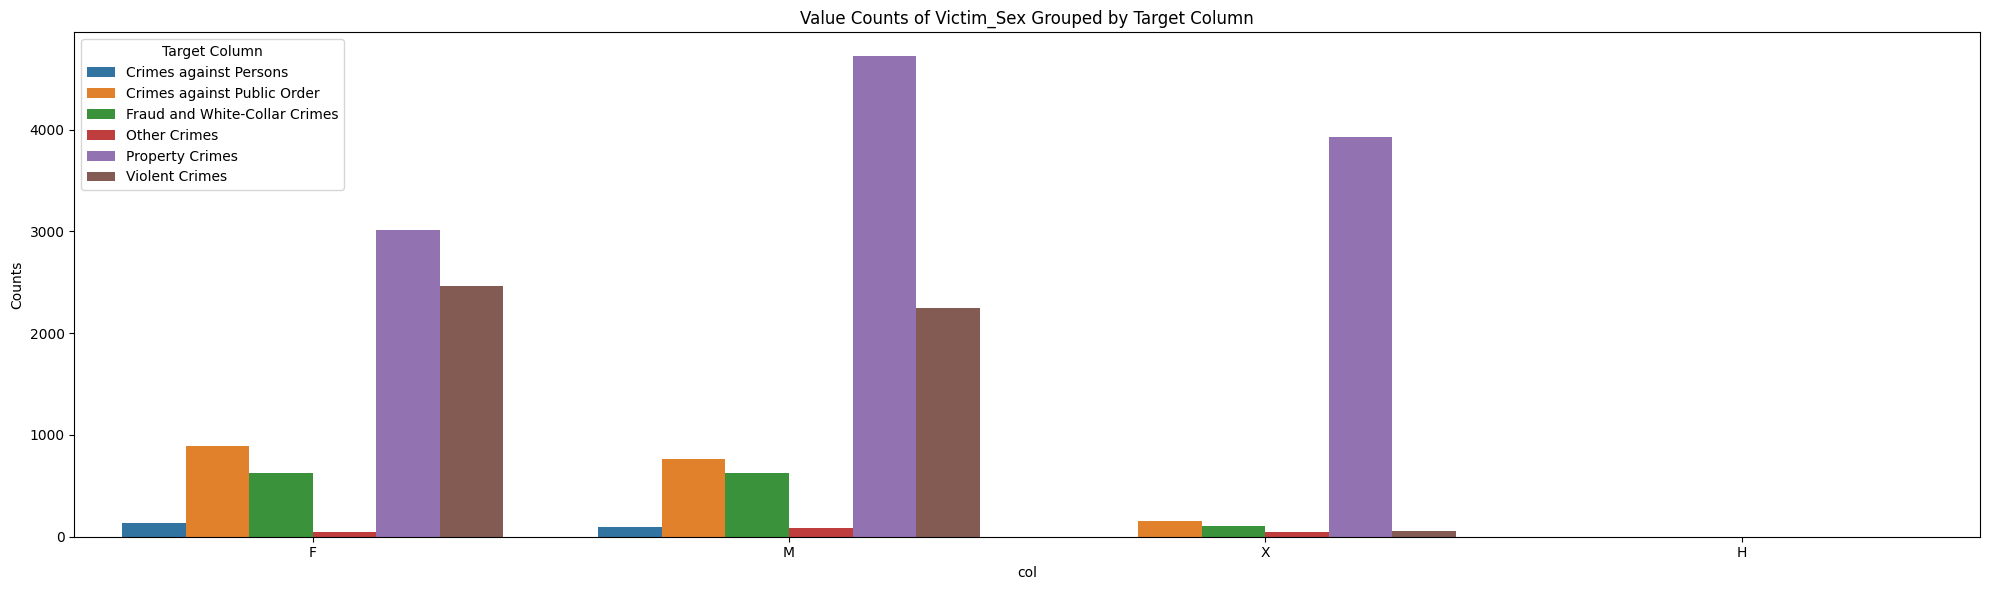

In [9]:
plot_counts('Victim_Sex',train_df)
plot_counts_hue('Victim_Sex',train_df)
#for the victim sex column we see a trend that most victims are male but the number of female victims is not that far off from the male numbers
#the counts for the other two columns is significantly lower than these but that might be because a majority of the population is within the binary
#male and female classification of gender
#proportionaly females are more likely to be victims of violent crime

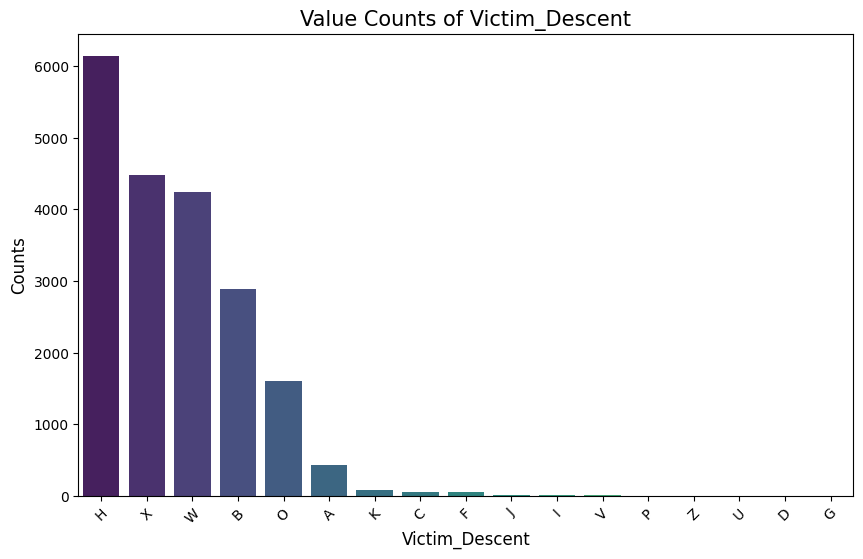

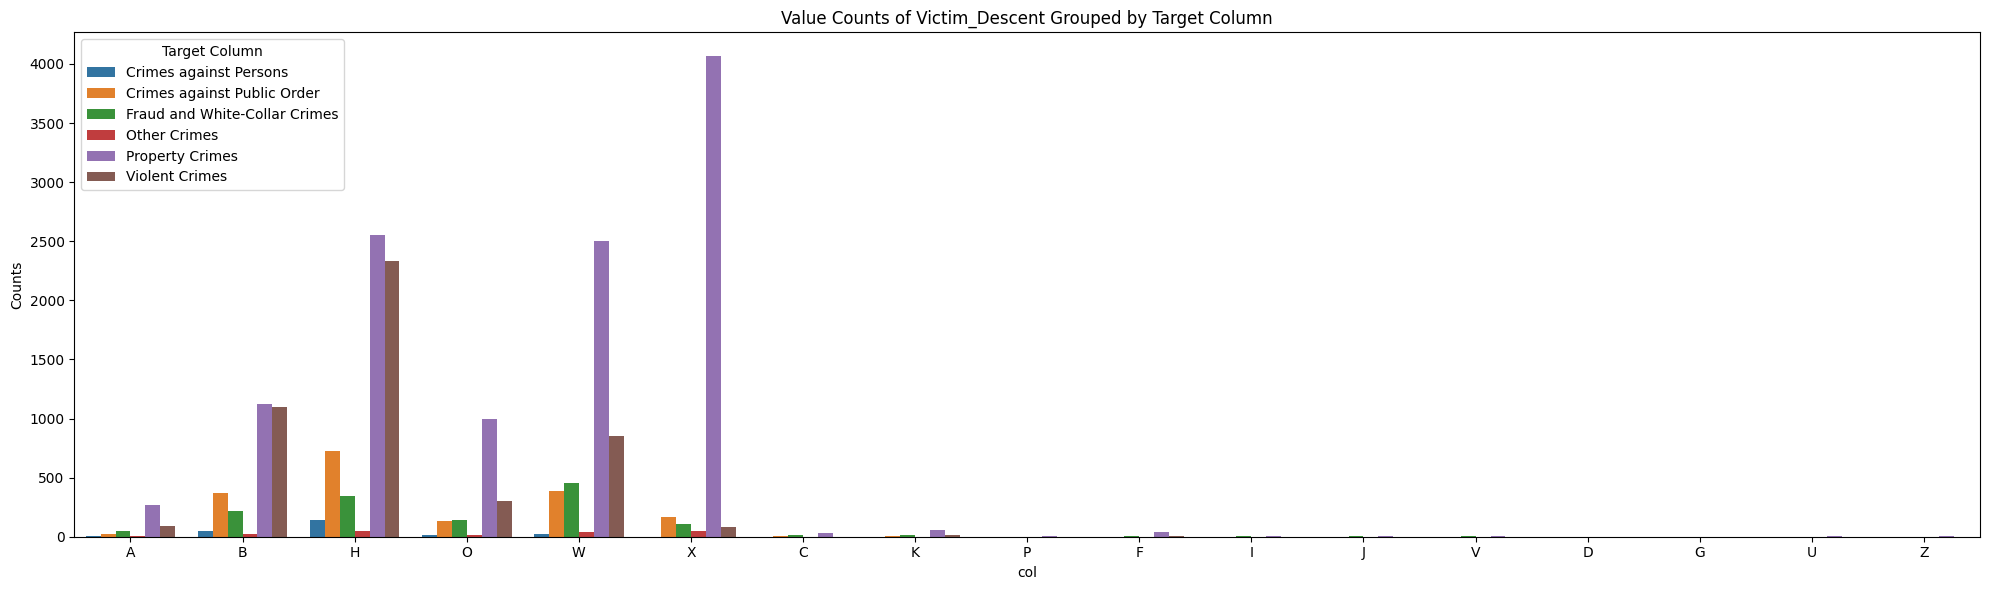

In [10]:
plot_counts('Victim_Descent',train_df)
plot_counts_hue('Victim_Descent',train_df)
#most of the crimes are committed against the people of hispanic(H) descent from this dataset
#white(W) and black/african american(B) are the next two most common descents of the victims in the dataset

Victim_Descent
H    0.488777
B    0.229494
W    0.178519
O    0.064191
A    0.018670
X    0.016992
K    0.002517
F    0.000420
J    0.000210
I    0.000210
Name: proportion, dtype: float64


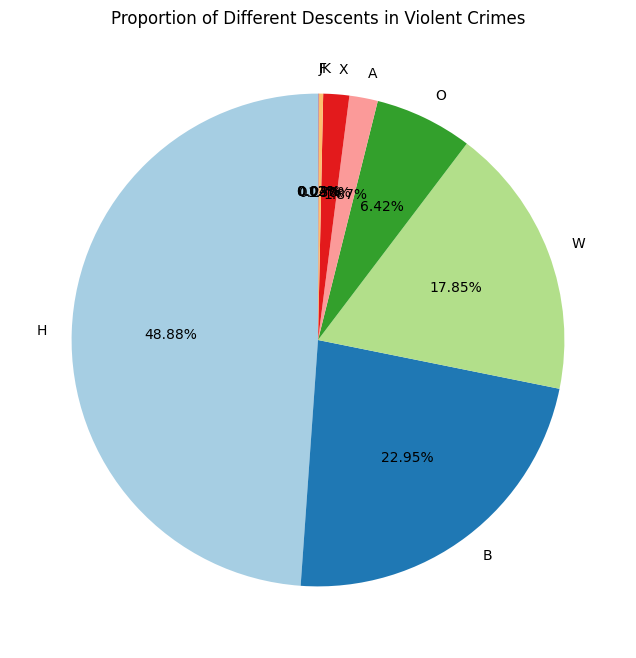

In [11]:
#proportionally the people of black and hispanic descent are more likely to be victims of violent crimes
#71.83% of victims of violent crimes are of either hispanic or black descent
violent_crimes = train_df[train_df['Crime_Category']=='Violent Crimes']
descent_counts = violent_crimes['Victim_Descent'].value_counts(normalize=True)
print(descent_counts)
plt.figure(figsize=(8, 8))
descent_counts.plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Proportion of Different Descents in Violent Crimes')
plt.ylabel('')
plt.show()

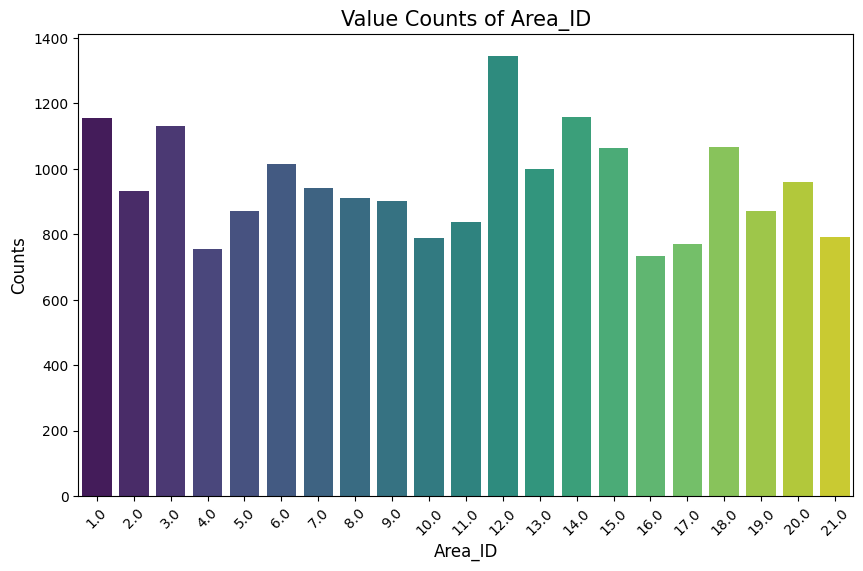

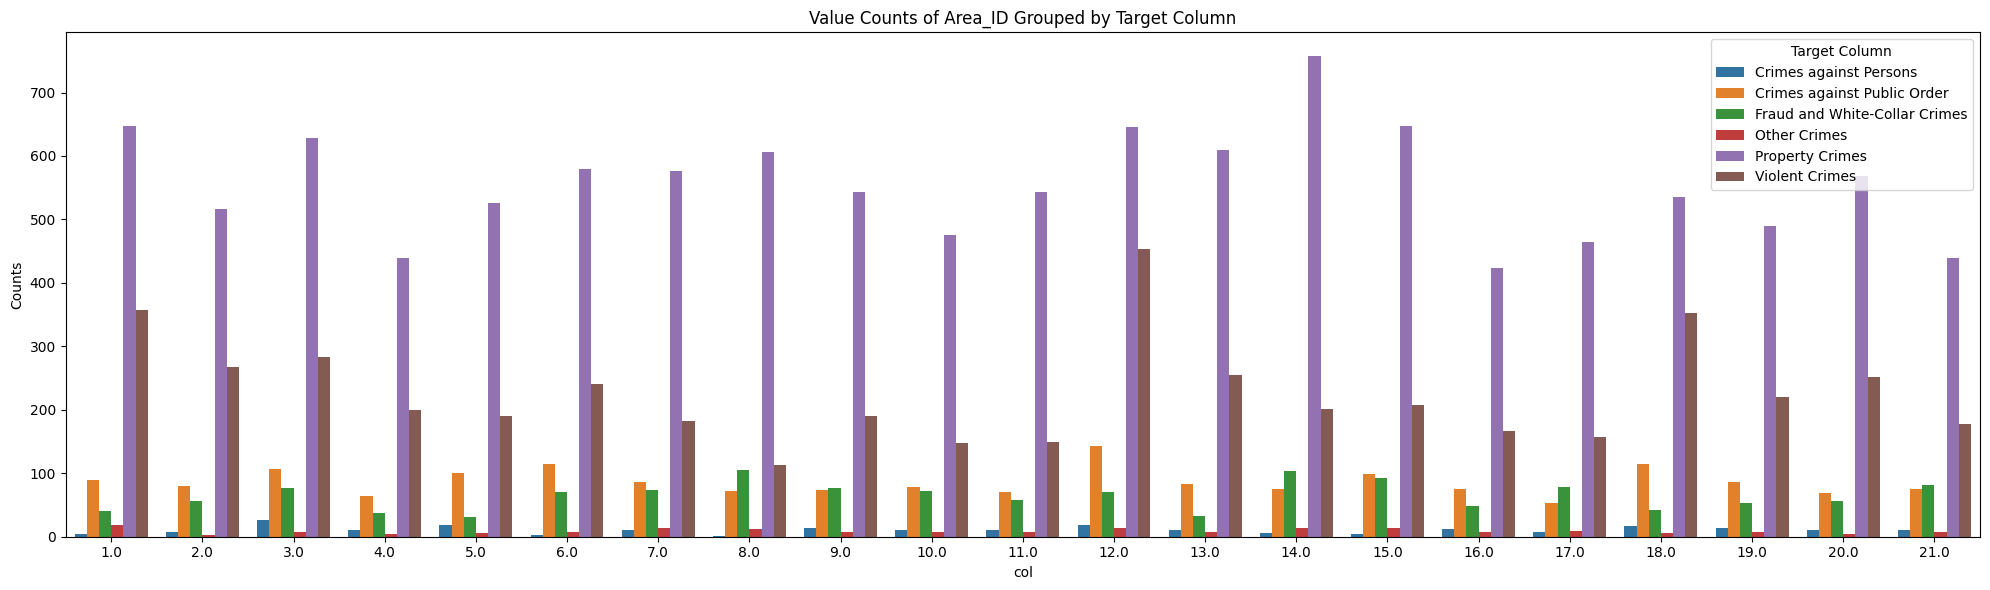

In [12]:
plot_counts('Area_ID',train_df)
plot_counts_hue('Area_ID',train_df)
#area ids 12 and 14 seem to be the hotspots with 1 and 3 being close behind them
#area id 12 has the highest number of violent crimes too

Part 1-2
1.0    11637
2.0     8363
Name: count, dtype: int64


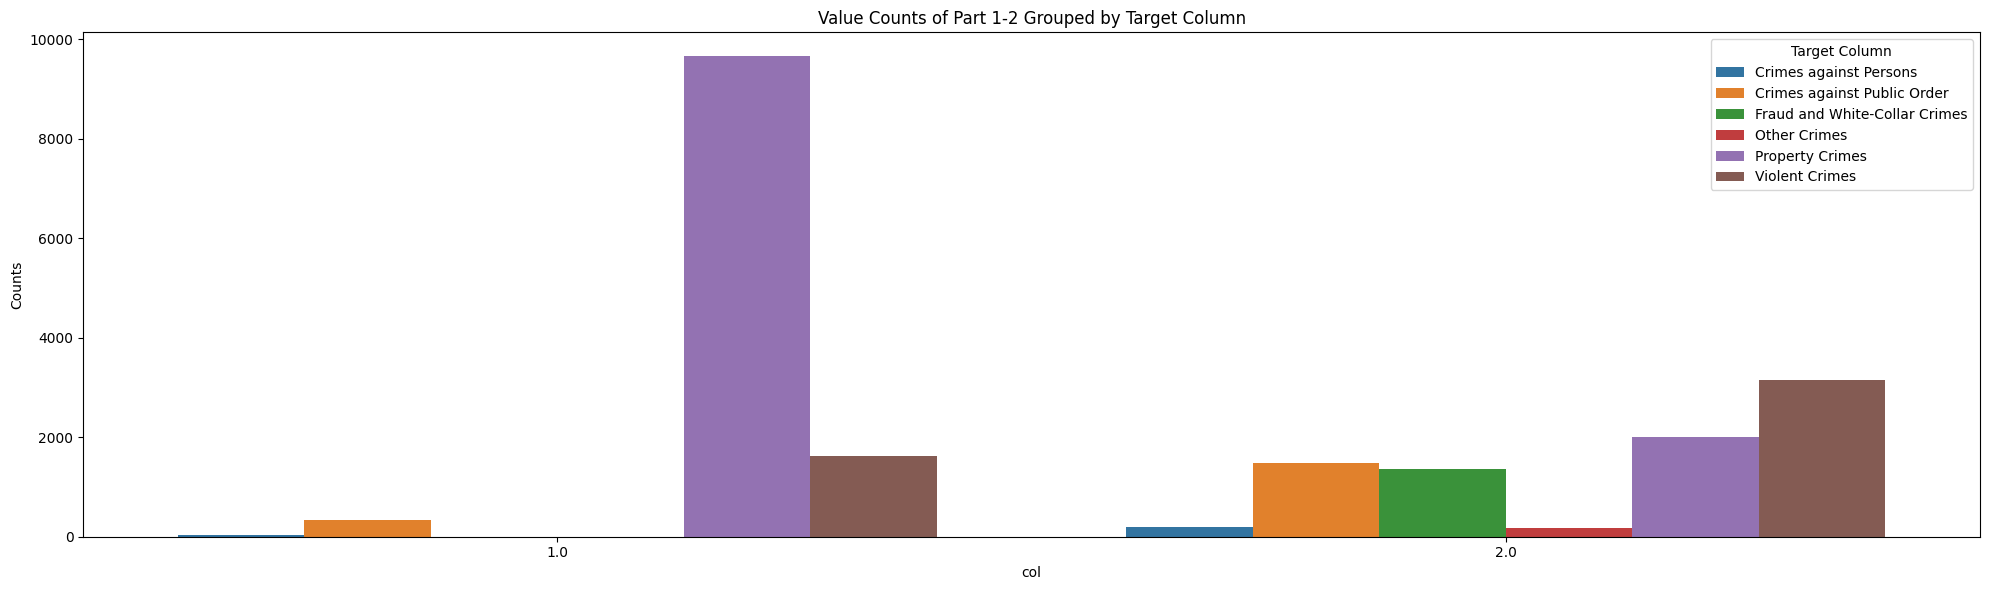

In [13]:
#the dataset description says this column is a 'Crime classification' although what specifically that means is unclear
print(train_df['Part 1-2'].value_counts())
plot_counts_hue('Part 1-2',train_df)
#the value counts are more for part 1
#the crimes in part 1 seem to be mostly related to property crimes

In [14]:
#importing required libraries for preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

#editing the modus operandi columnn 
"""def count(numbers):
    return len(str(numbers).split(' '))
train_df['Modus_Operandi'] = train_df['Modus_Operandi'].apply(count)
test_df['Modus_Operandi'] = test_df['Modus_Operandi'].apply(count)"""
#I was using the number of activities associated with the suspect as this column has a lot of unique 4 digit codes and it would help me glean some information
#without adding too many columns but that was limiting my models to around 0.8 to 0.85 accuracy so instead I used tfidf vectorizer to get the codes out of this
#column and then used lda to reduce the dimenstionality of the dataset this increased accuracy significantly.

train_df['Modus_Operandi'] = train_df['Modus_Operandi'].fillna("0")
test_df['Modus_Operandi'] = test_df['Modus_Operandi'].fillna("0")
tfi = TfidfVectorizer(decode_error='ignore')
tfi_matrix_train = tfi.fit_transform(train_df['Modus_Operandi'])
tfi_matrix_test = tfi.transform(test_df['Modus_Operandi'])
tfidf_train = pd.DataFrame(tfi_matrix_train.toarray(), columns = tfi.get_feature_names_out())
tfidf_test = pd.DataFrame(tfi_matrix_test.toarray(),columns = tfi.get_feature_names_out())
train_df = pd.concat([train_df,tfidf_train],axis=1)
test_df = pd.concat([test_df,tfidf_test],axis=1)

#one hot encoding columns 
encode = ['Area_ID', 'Victim_Sex', 'Victim_Descent', 'Status', 'Part 1-2','Weapon_Used_Code','Premise_Code']
OHEncoder = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')

train_encoded = OHEncoder.fit_transform(train_df[encode])
train_encoded_df = pd.DataFrame(train_encoded,columns = OHEncoder.get_feature_names_out(encode))
train_df = pd.concat([train_df,train_encoded_df],axis=1)
train_df.drop(encode, axis=1, inplace=True)

test_encoded = OHEncoder.transform(test_df[encode])
test_encoded_df = pd.DataFrame(test_encoded,columns = OHEncoder.get_feature_names_out(encode))
test_df = pd.concat([test_df,test_encoded_df],axis=1)
test_df.drop(encode,axis=1,inplace=True)

"""#ordinally encoding columns
OEncoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ordin = ['Location', 'Reporting_District_no', 'Premise_Code']
#train_df['Weapon_Used_Code'] = train_df['Weapon_Used_Code'].fillna(0)#filling in the nan values with 0 so that encoder can work
#test_df['Weapon_Used_Code'] = test_df['Weapon_Used_Code'].fillna(0)
train_df[ordin] = OEncoder.fit_transform(train_df[ordin])
test_df[ordin] = OEncoder.transform(test_df[ordin])"""

#standard scaling the features
scale = ['Latitude', 'Longitude','Time_Occurred','Reporting_District_no','Victim_Age','Month_Reported','Day_Reported','Month_Occurred','Day_Occurred']
scaler = StandardScaler()
train_df[scale] = scaler.fit_transform(train_df[scale])
test_df[scale] = scaler.transform(test_df[scale])

#dropping required columns
columns_to_drop = ['Location','Cross_Street', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description','Date_Reported','Date_Occurred','Modus_Operandi']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [15]:
#label encoding the target variable
labels = LabelEncoder()
train_df['target'] = labels.fit_transform(train_df['Crime_Category'])
train_df.drop(columns=['Crime_Category'], inplace=True)

classes = labels.classes_
for index, class_label in enumerate(classes): 
    print(f"Class label: {class_label}, Encoded value: {index}")# Display the classes with their encoded values

Class label: Crimes against Persons, Encoded value: 0
Class label: Crimes against Public Order, Encoded value: 1
Class label: Fraud and White-Collar Crimes, Encoded value: 2
Class label: Other Crimes, Encoded value: 3
Class label: Property Crimes, Encoded value: 4
Class label: Violent Crimes, Encoded value: 5


In [16]:
#Getting the support for each of the classes in the dataset
print(train_df['target'].value_counts().sort_index())

target
0      225
1     1808
2     1355
3      179
4    11666
5     4767
Name: count, dtype: int64


### **Classes 0 and 3 (crimes against persons and other crimes) have very low support compared to the other classes. Despite trying oversampling techniques like SMOTE and ADASYN from imbalanced-learn, these techniques do not significantly improve model performance and actually reduce overall accuracy.**

### **Although class 2 has a low number of occurrences, the models achieve better F1 scores for this class, indicating that class 2 is well-separated from the rest of the data. In contrast, class 1, which is somewhat more frequent, has poorer separation.**

### **Classes 4 and 5 represent the majority of samples in the dataset and have similar F1 scores.**

In [17]:
lda = LinearDiscriminantAnalysis()
X = train_df.drop('target',axis='columns')
y = train_df['target'] #seperating the target variable
X_lda = lda.fit_transform(X,y)
X_lda_test = lda.transform(test_df)
print(X_lda.shape)
print(X_lda_test.shape)
X_train, X_val, y_train, y_val = train_test_split(X_lda, y, test_size=0.2, random_state=42) #splitting into training and validation sets

(20000, 5)
(5000, 5)


In [18]:
temp_df = pd.concat([pd.DataFrame(X_lda),y],axis=1)
correlation_matrix=temp_df.corr()
print(correlation_matrix.round(5))
"""plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix with Target Column')
plt.show()"""
#the plot is not useful since the correlation of the variables with each other is going to be 0 because of lda
#columns 1,2 and 3 have a significant correlation with the target variable

              0        1        2        3        4   target
0       1.00000 -0.00000 -0.00000 -0.00000 -0.00000  0.03961
1      -0.00000  1.00000 -0.00000  0.00000 -0.00000  0.61393
2      -0.00000 -0.00000  1.00000  0.00000 -0.00000 -0.49602
3      -0.00000  0.00000  0.00000  1.00000 -0.00000 -0.25674
4      -0.00000 -0.00000 -0.00000 -0.00000  1.00000 -0.03174
target  0.03961  0.61393 -0.49602 -0.25674 -0.03174  1.00000


"plt.figure(figsize=(12, 12))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')\nplt.title('Correlation Matrix with Target Column')\nplt.show()"

### **Linear Discriminant Analysis is a dimensionality reduction technique similiar to pca but instead of maximizing the variance in the dataset it maximizes the seperation of the different classes in the dataset. It gives us a maximum of k-1 features where k is the number of classes in the dataset.**

# Linear Discriminant Analysis (LDA) Steps

## Step 1: Compute the Mean Vectors
Calculate the mean vector for each class. If you have c classes and each class i has \( n_i \) samples, the mean vector for class i is:

$$ \mu_i = \frac{1}{n_i} \sum_{x \in C_i} x $$

where \( C_i \) is the set of samples in class \( i \).

## Step 2: Compute the Scatter Matrices
### Within-Class Scatter Matrix (\( S_W \))
The within-class scatter matrix measures the scatter (spread) of data points within each class. It is defined as:

$$ S_W = \sum_{i=1}^c S_i $$

where \( S_i \) is the scatter matrix for class \( i \):

$$ S_i = \sum_{x \in C_i} (x - \mu_i)(x - \mu_i)^T $$

### Between-Class Scatter Matrix (\( S_B \))
The between-class scatter matrix measures the scatter of the mean vectors relative to the overall mean. It is defined as:

$$ S_B = \sum_{i=1}^c n_i (\mu_i - \mu)(\mu_i - \mu)^T $$

where \(\mu\) is the overall mean vector of the data:

$$ \mu = \frac{1}{N} \sum_{i=1}^c \sum_{x \in C_i} x $$

and \( N \) is the total number of samples.

## Step 3: Solve the Generalized Eigenvalue Problem
To find the optimal linear discriminants, solve the following generalized eigenvalue problem:

$$ S_W^{-1} S_B v = \lambda v $$

Here, \(\lambda\) is the eigenvalue and \(v\) is the eigenvector. The eigenvectors corresponding to the largest eigenvalues form the transformation matrix \( W \).

The default solver for the LDA implementation in sklearn is SVD(Singular Value Decomposition). This performs the analysis without explicitly computing the within class scatter matrix.

## Step 4: Form the Transformation Matrix
Select the \( k \) eigenvectors corresponding to the \( k \) largest eigenvalues to form the transformation matrix \( W \):

$$ W = [v_1, v_2, \ldots, v_k] $$

## Step 5: Transform the Data
Project the original data onto the new subspace using the transformation matrix \( W \):

$$ y = W^T x $$

where \( x \) is the original data point and \( y \) is the transformed data point.


In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

#defining a function that checks if the model is overfitting or underfitting
#the graph alone might be misleading because of the change in scales with the change in scores so we need to pay attention to the scales 
#and the printed values for a more complete insight
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Make predictions on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate accuracy scores and the difference
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_diff = train_accuracy - test_accuracy
    #If the train accuracy and test accuracy are close together(i.e. the accuracy difference is low) then the model is not overfitting or underfitting
    #If there is a large difference in the training and test accuracy then the model is overfitting
    #If both training and test accuracies are low then the model is underfitting
    
    # Print accuracy results
    print(f"Training Accuracy: {train_accuracy:.6f}")
    print(f"Test Accuracy: {test_accuracy:.6f}")
    print(f"Accuracy Difference: {accuracy_diff:.6f}")
    
    #compute roc-auc scores and the difference
    y_train_bin = label_binarize(y_train, classes=model.classes_)
    y_test_bin = label_binarize(y_test, classes=model.classes_)
    train_probs = model.predict_proba(X_train)
    test_probs = model.predict_proba(X_test)
    train_roc_auc = roc_auc_score(y_train_bin, train_probs, multi_class='ovr')
    test_roc_auc = roc_auc_score(y_test_bin, test_probs, multi_class='ovr')
    roc_auc_diff = train_roc_auc - test_roc_auc
    
    #print roc-auc scores
    print(f"Training roc-auc: {train_roc_auc:.6f}")
    print(f"Test roc-auc: {test_roc_auc:.6f}")
    print(f"roc-auc Difference: {roc_auc_diff:.6f}")

    # Plot learning curves
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc_ovr')
    
    # Mean and std deviation for training and test scores
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Plot learning curves
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.2)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return

In [20]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#using stratified kfold to preserve the imbalance of the data between the training and testing sets

In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
parameters = {
    'C':[0.1,1,10,20],
    'penalty':['l2'],#from previous runs this performs better than elasitcnet or l1
    'solver':['saga','newton-cg'],
    'tol':[0.01,0.001,0.0001],
    'max_iter':[500],
    'multi_class':['auto']
}

clf_lgr = GridSearchCV(logreg,parameters,cv=skf,n_jobs=-1)
clf_lgr.fit(X_train,y_train)
print(clf_lgr.best_params_)

{'C': 10, 'max_iter': 500, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}


In [22]:
best_model_lgr = clf_lgr.best_estimator_
y_pred_lgr = best_model_lgr.predict(X_val)
print(accuracy_score(y_pred_lgr,y_val))
report = classification_report(y_pred_lgr,y_val)
print(report)

0.94375
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        27
           1       0.84      0.85      0.85       370
           2       0.92      0.92      0.92       265
           3       0.23      0.57      0.33        14
           4       0.98      0.97      0.98      2313
           5       0.94      0.92      0.93      1011

    accuracy                           0.94      4000
   macro avg       0.75      0.82      0.77      4000
weighted avg       0.95      0.94      0.95      4000



Training Accuracy: 0.946625
Test Accuracy: 0.943750
Accuracy Difference: 0.002875
Training roc-auc: 0.989786
Test roc-auc: 0.993176
roc-auc Difference: -0.003390


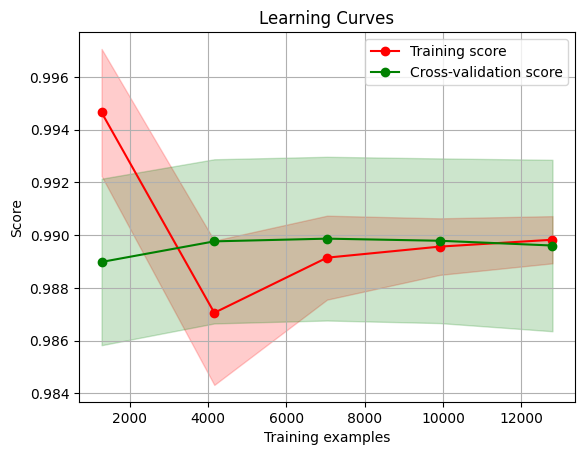

In [23]:
evaluate_model(best_model_lgr,X_train,y_train,X_val,y_val)

#### **Since the support for labels 0 and 3(crime against persons, other crimes) is very low, the precision and f1 scores are low as well.**

#### **The model does not overfit as the two accuracy scores are relatively close to each other and the difference in roc-auc score is low as well.**

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid_knn = {
    #'n_neighbors': [20,30,35,40],
    'n_neighbors': [100,150,180],
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan'],
    'n_jobs':[-1]
}

clf_knn = GridSearchCV(knn,param_grid_knn,cv=skf,n_jobs=-1)
clf_knn.fit(X_train,y_train)
print(clf_knn.best_params_)


{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 100, 'weights': 'distance'}


In [25]:
best_model_knn = clf_knn.best_estimator_
y_pred_knn = best_model_knn.predict(X_val)
print(accuracy_score(y_pred_knn,y_val))
report = classification_report(y_pred_knn,y_val)
print(report)

0.9505
              precision    recall  f1-score   support

           0       0.53      0.63      0.58        27
           1       0.87      0.84      0.85       387
           2       0.94      0.95      0.95       266
           3       0.34      0.80      0.48        15
           4       0.98      0.98      0.98      2292
           5       0.95      0.93      0.94      1013

    accuracy                           0.95      4000
   macro avg       0.77      0.85      0.80      4000
weighted avg       0.95      0.95      0.95      4000



Training Accuracy: 1.000000
Test Accuracy: 0.950500
Accuracy Difference: 0.049500
Training roc-auc: 1.000000
Test roc-auc: 0.991868
roc-auc Difference: 0.008132


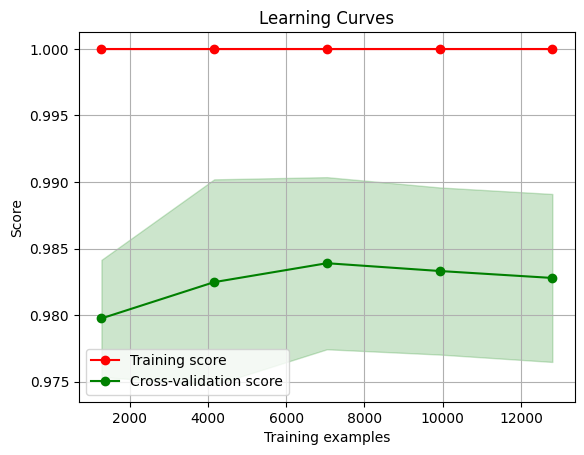

In [26]:
evaluate_model(best_model_knn,X_train,y_train,X_val,y_val)

#### **The performance of the k-neighbors classifier is slightly better overall but it does not perform significantly better for the classes with low support. Using values too high might be harmful because of the imbalance in the dataset even with the weights parameters set to distance.**

#### **From the score curves the we can see that the model might be overfitting but the cros validation score is also above 0.98 consistently so the model is still generalising well nonetheless.**

In [27]:
from sklearn.svm import SVC
param_grid_svc={
    'C':[30,40,50],
    'tol':[0.001,0.01],
    'kernel':['rbf'],#performs the best
    'class_weight':['balanced'],#higher weights for classes with low support 
    'gamma':['scale'],#prevents overfitting
}
svc = SVC(probability=True)
clf_svc = GridSearchCV(svc,param_grid_svc,cv=skf,n_jobs=-1)
clf_svc.fit(X_train,y_train)
print(clf_svc.best_params_)

{'C': 30, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001}


In [28]:
best_model_svc = clf_svc.best_estimator_
y_pred_svc = best_model_svc.predict(X_val)
print(accuracy_score(y_pred_svc,y_val))
report = classification_report(y_pred_svc,y_val)
print(report)

0.92525
              precision    recall  f1-score   support

           0       0.81      0.29      0.42        91
           1       0.83      0.82      0.83       379
           2       0.93      0.97      0.95       255
           3       0.74      0.27      0.39        97
           4       0.96      1.00      0.98      2218
           5       0.89      0.92      0.91       960

    accuracy                           0.93      4000
   macro avg       0.86      0.71      0.75      4000
weighted avg       0.92      0.93      0.92      4000



Training Accuracy: 0.933562
Test Accuracy: 0.925250
Accuracy Difference: 0.008312
Training roc-auc: 0.993448
Test roc-auc: 0.987988
roc-auc Difference: 0.005460


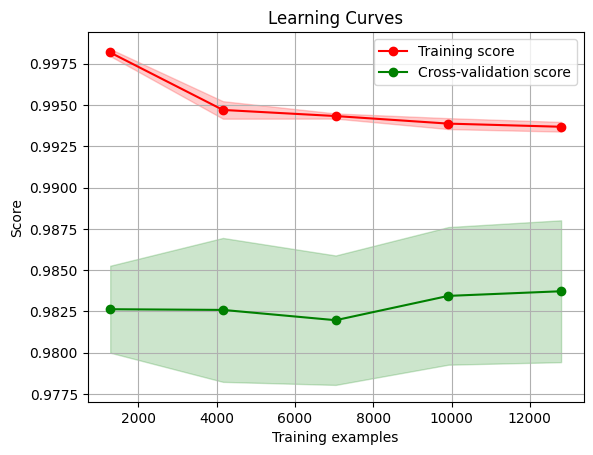

In [29]:
evaluate_model(best_model_svc,X_train,y_train,X_val,y_val)

#### **The balanced weight parameter for the SVC model was expected to improve performance on low support classes. However, it does not seem to outperform the previous models.**

#### **Additionally, the learning curves suggest that the model was initially overfitting. Over time, the training and testing scores gradually converge to similar values, indicating that the model is starting to generalize better.**

In [30]:
from sklearn.tree import DecisionTreeClassifier
param_grid_cart={
    'max_depth':[5,7,9],
    'max_leaf_nodes':[31,41,51],
    'criterion':['gini','entropy'],
    'min_samples_split':[2,4,6]
}
cart = DecisionTreeClassifier()
clf_cart = GridSearchCV(cart,param_grid_cart,cv=skf,n_jobs=-1)
clf_cart.fit(X_train,y_train)
print(clf_cart.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 51, 'min_samples_split': 2}


In [31]:
best_model_cart=clf_cart.best_estimator_
y_pred_cart = best_model_cart.predict(X_val)
print(accuracy_score(y_pred_cart,y_val))
print(classification_report(y_pred_cart,y_val))

0.9485
              precision    recall  f1-score   support

           0       0.47      0.71      0.57        21
           1       0.86      0.84      0.85       386
           2       0.94      0.95      0.95       262
           3       0.51      0.78      0.62        23
           4       0.98      0.98      0.98      2310
           5       0.94      0.93      0.94       998

    accuracy                           0.95      4000
   macro avg       0.78      0.87      0.82      4000
weighted avg       0.95      0.95      0.95      4000



Training Accuracy: 0.952688
Test Accuracy: 0.948500
Accuracy Difference: 0.004188
Training roc-auc: 0.991590
Test roc-auc: 0.986786
roc-auc Difference: 0.004805


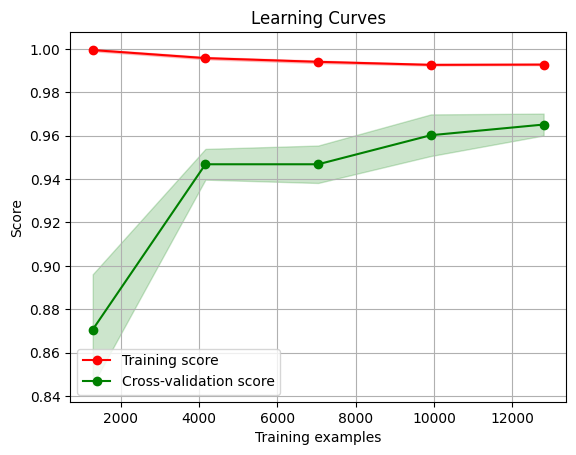

In [32]:
evaluate_model(best_model_cart,X_train,y_train,X_val,y_val)

#### **The model does start out with overfitting but over time it generalized better although the roc-auc score difference is slightly lower compared to the other models as well.**

#### **The model performs well on classes with low support compared to the previous models.** 

0.95075
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        22
           1       0.90      0.82      0.86       414
           2       0.93      0.98      0.96       252
           3       0.37      0.81      0.51        16
           4       0.98      0.98      0.98      2303
           5       0.94      0.93      0.94       993

    accuracy                           0.95      4000
   macro avg       0.77      0.88      0.81      4000
weighted avg       0.95      0.95      0.95      4000

Training Accuracy: 0.954375
Test Accuracy: 0.950750
Accuracy Difference: 0.003625
Training roc-auc: 0.996164
Test roc-auc: 0.995546
roc-auc Difference: 0.000619


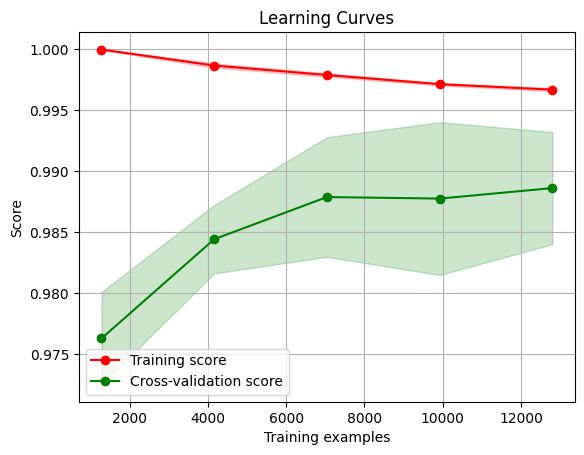

0.948
              precision    recall  f1-score   support

           0       0.53      0.74      0.62        23
           1       0.90      0.80      0.85       421
           2       0.90      0.98      0.94       243
           3       0.43      0.79      0.56        19
           4       0.98      0.98      0.98      2302
           5       0.94      0.93      0.93       992

    accuracy                           0.95      4000
   macro avg       0.78      0.87      0.81      4000
weighted avg       0.95      0.95      0.95      4000

Training Accuracy: 0.952500
Test Accuracy: 0.948000
Accuracy Difference: 0.004500
Training roc-auc: 0.928896
Test roc-auc: 0.918775
roc-auc Difference: 0.010121


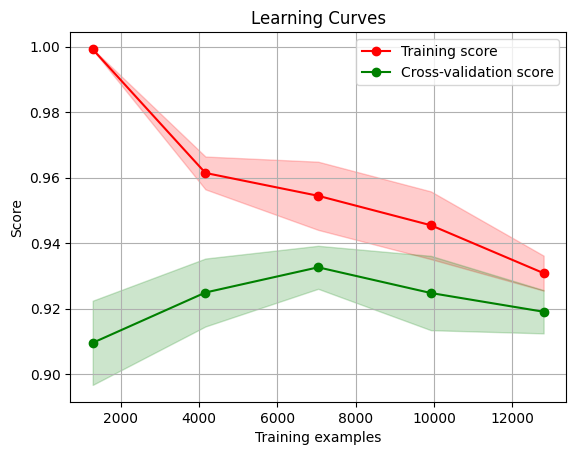

In [33]:
from sklearn.ensemble import VotingClassifier,BaggingClassifier,AdaBoostClassifier
#implementing ensemble models from sklearn bagging to reduce the variance in the dataset and boosting to reduce the bias in the dataset
#bagging also reduces overfitting in the models so this should improve the generalisation to the unseen data

bagging = BaggingClassifier(estimator=best_model_cart,n_estimators=100,random_state=42,n_jobs=-1)
bagging.fit(X_train,y_train)
y_pred_bagging = bagging.predict(X_val)
print(accuracy_score(y_pred_bagging,y_val))
print(classification_report(y_pred_bagging,y_val))
evaluate_model(bagging,X_train,y_train,X_val,y_val)

boosting = AdaBoostClassifier(estimator=best_model_cart,n_estimators=15,learning_rate=0.01,algorithm='SAMME')
boosting.fit(X_train,y_train)
y_pred_boosting= boosting.predict(X_val)
print(accuracy_score(y_pred_boosting,y_val))
print(classification_report(y_pred_boosting,y_val))
evaluate_model(boosting,X_train,y_train,X_val,y_val)

In [34]:
voting_model = VotingClassifier(estimators=[
    ('bagging', bagging),
    ('boosting', boosting)
], voting='soft')
#I included knn in the voting model but it increased the roc auc difference considerably which might decrease the generalization and performance of the voting
voting_model.fit(X_train, y_train)
y_pred_vote = voting_model.predict(X_val)
print(accuracy_score(y_pred_vote,y_val))
print(classification_report(y_pred_vote,y_val))

0.95075
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        22
           1       0.90      0.82      0.86       414
           2       0.93      0.98      0.96       252
           3       0.37      0.81      0.51        16
           4       0.98      0.98      0.98      2303
           5       0.94      0.93      0.94       993

    accuracy                           0.95      4000
   macro avg       0.77      0.88      0.81      4000
weighted avg       0.95      0.95      0.95      4000



Training Accuracy: 0.954250
Test Accuracy: 0.950750
Accuracy Difference: 0.003500
Training roc-auc: 0.996160
Test roc-auc: 0.995540
roc-auc Difference: 0.000620


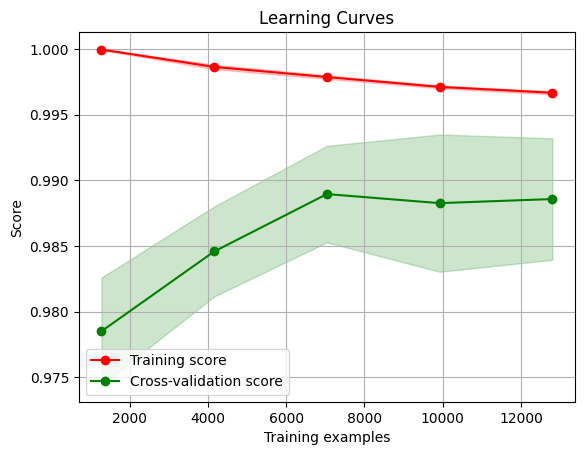

In [35]:
evaluate_model(voting_model,X_train,y_train,X_val,y_val)

#### **The voting model with the tuned decision tree classifier along with the ensemble methods has performed the best with the preprocessing I have done on the dataset. Like the decision trees even for the minority classes 0 and 3 they have a slightly better f1-score compared to the other models.**

#### **Moreover both the accuracy difference and the roc auc score difference are very low indicating this model is not overfitting.**

In [36]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
param_grid_mlp = {
    'hidden_layer_sizes':[(5,10,20,10,5)],
    'activation':['logistic'],
    'alpha':[0.01,0.001],
    'learning_rate':['adaptive'],
    'learning_rate_init':[0.1,0.01,0.001],
    'solver':['adam',],
    'max_iter':[300],
    'warm_start':[True]
    
}

clf_mlp = GridSearchCV(mlp,param_grid_mlp,cv=skf,n_jobs=-1,verbose=0)
clf_mlp.fit(X_train,y_train)
print(clf_mlp.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (5, 10, 20, 10, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam', 'warm_start': True}


In [37]:
best_model_mlp = clf_mlp.best_estimator_
y_pred_mlp = best_model_mlp.predict(X_val)
print(accuracy_score(y_pred_mlp,y_val))
print(classification_report(y_pred_mlp,y_val))

0.94725
              precision    recall  f1-score   support

           0       0.62      0.65      0.63        31
           1       0.89      0.81      0.85       410
           2       0.95      0.92      0.94       275
           3       0.11      0.57      0.19         7
           4       0.98      0.98      0.98      2294
           5       0.93      0.94      0.94       983

    accuracy                           0.95      4000
   macro avg       0.75      0.81      0.76      4000
weighted avg       0.95      0.95      0.95      4000



Training Accuracy: 0.948250
Test Accuracy: 0.947250
Accuracy Difference: 0.001000
Training roc-auc: 0.986560
Test roc-auc: 0.991219
roc-auc Difference: -0.004659


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


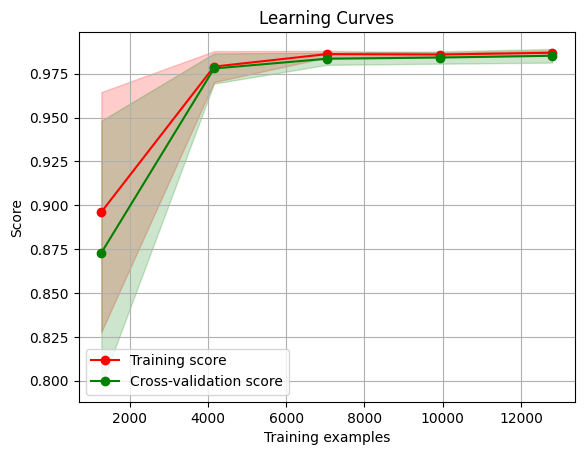

In [38]:
evaluate_model(best_model_mlp,X_train,y_train,X_val,y_val)

#### **I've observed instability with the MLP classifier, despite using the same parameters, the model's performance varies significantly, and sometimes it fails to converge at all. This instability is likely due to insufficient hyperparameter tuning but tuning the model further would require testing across a broader range of parameters, which would significantly increase the already lengthy training time. Given these challenges, the MLP classifier may not be the most practical choice for this task.**

#### **From what I have learned in the theory course and in my own experience using the MLP classifier, it is a powerful technique. Even when the model doesn't fully converge, it still achieves performance very close to the best model I trained for this dataset.**

#### **Among all the models that I tested I have decided to submit with the voting model.**

#### **The ensemble includes both high-bias (boosting) and high-variance (bagging) models. This diversity can help the voting model generalize better by leveraging the strengths of both the techniques.**

In [39]:
final_model = voting_model
final_model.fit(X_lda,y)
prediction_ = final_model.predict(X_lda_test)
prediction = labels.inverse_transform(prediction_)
submission = pd.DataFrame(columns=['ID','Crime_Category'])
submission['ID'] = [i for i in range(1,len(prediction)+1)]
submission['Crime_Category'] = prediction
#submission['Unnamed: 2'] = [np.nan]*len(prediction)
submission.to_csv('submission.csv', index=False) #final submission csv file